In [1]:
import torch , gc
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
import os

%matplotlib inline

In [2]:
stats = (0.4086, 0.4133, 0.3878),(0.2692, 0.2494, 0.2762)

In [3]:
image_size = 256
batch_size = 32

In [4]:
train_tfms = T.Compose([T.ToTensor(),T.Normalize(*stats)])
DIR_PATH = 'painter_data'
train_ds = ImageFolder(DIR_PATH,transform=train_tfms)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=3,pin_memory=True)

In [5]:
def denorm(img):
    return img*stats[1][0]+stats[0][0]

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
device = get_default_device()
device

device(type='cuda')

In [8]:
train_dl = DeviceDataLoader(train_dl,device)

In [9]:
discriminator = nn.Sequential(
    #3x256x256
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    #64x128x128

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=True),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    #128x64x64

    nn.Conv2d(128,128,kernel_size=4,stride=2,padding=1,bias=True),
    nn.LeakyReLU(0.2,inplace=True),
    #128x32x32

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    #256x16x16

    nn.Conv2d(256,256,kernel_size=4,stride=2,padding=1,bias=True),
    nn.LeakyReLU(0.2,inplace=True),
    #256x8x8

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    #512x4x4

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    #1x1x1

    nn.Flatten(),
    nn.Sigmoid()
)

In [10]:
discriminator = to_device(discriminator,device)
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (12): LeakyReLU(negative_slope=0.2, inplace=True)
  (13): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [11]:
latent_size = 128

In [12]:
generator = nn.Sequential(
    #latentx1x1
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #512x4x4

    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #256x8x8

    nn.ConvTranspose2d(256,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.ReLU(True),
    #256x16x16

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #128x32x32

    nn.ConvTranspose2d(128,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.ReLU(True),
    #128x64x64

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=True),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #64x128x128

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
    #3x256x256
)

In [13]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)


torch.Size([32, 3, 256, 256])


In [14]:
generator = to_device(generator,device)
generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): ReLU(inplace=True)
  (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (12): ReLU(inplace=True)
  (13): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (14): BatchNorm2d(64, eps=1e-05, momentum

In [15]:
def d_train(real_images,opt_d):
    opt_d.zero_grad()

    #pass real
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = F.binary_cross_entropy(real_preds,real_targets)
    real_score = torch.mean(real_preds).item()

    #generate fake_img
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)

    #passing fake through disc
    fake_targets = torch.zeros(fake_images.size(0),1,device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()

    #updating disc weights
    loss = real_loss+fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [16]:
def g_train(opt_g):
    opt_g.zero_grad()

    #generate fake img
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)

    #FOOLING DISCRIMINATOR
    preds = discriminator(fake_images)
    target = torch.ones(batch_size,1,device=device)
    loss = F.binary_cross_entropy(preds,target)

    #updating gene. weights
    loss.backward()
    opt_g.step()
    return loss.item()

In [17]:
# saving images
sample_dir = 'paint_gen2'
os.makedirs(sample_dir,exist_ok=True)

In [18]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'gen-paint1-{}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [19]:
fixed_latent = torch.randn(32,latent_size,1,1,device=device)

In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving gen-paint1-0.png


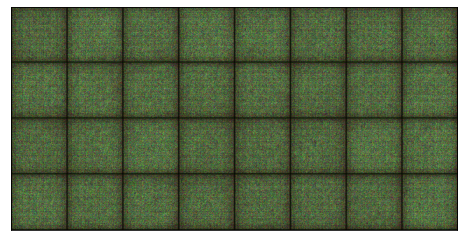

In [21]:
save_samples(0, fixed_latent)

In [22]:
def fit(epochs,lr,start_idx =1):
    gc.collect()
    torch.cuda.empty_cache()

    g_losses = []
    d_losses = []
    real_scores = []
    fake_scores = []

    #optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
    opt_g = torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

    for epoch in range(epochs):
        for real_images,_ in train_dl:
            #disc train
            loss_d,real_score,fake_score = d_train(real_images,opt_d)
            #train_gen
            loss_g = g_train(opt_g)
        
        g_losses.append(loss_g)
        d_losses.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        #printing
        print("Epoch:",epoch+1," loss_g:",loss_g," loss_d:",loss_d," real_score:",real_score," fake_score:",fake_score)

        #saving
        save_samples(epoch+start_idx, fixed_latent,show=False)

    return g_losses,d_losses,real_scores,fake_scores

In [23]:
epochs = 3
lr = 0.00003

In [24]:
gc.collect()
torch.cuda.empty_cache()

In [25]:
his1 = fit(epochs,lr)

Epoch: 1  loss_g: 5.100730895996094  loss_d: 0.059799954295158386  real_score: 0.9611116647720337  fake_score: 0.019138695672154427
Saving gen-paint1-1.png


KeyboardInterrupt: 